In [ ]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#get the file
df=pd.read_csv('/content/drive/MyDrive/Forecasting/Canada Airport Data.csv')
df.head()


,Merged,Value
0,2022-01-01,"79,100"
1,2022-01-02,"72,224"
2,2022-01-03,"70,459"
3,2022-01-04,"64,980"
4,2022-01-05,"62,229"


In [ ]:
def conversion(data):
  data['Merged'] = pd.to_datetime(data['Merged'])
  data['Value'] = data['Value'].str.replace(',','').astype(int)
  data.columns = ['Date', 'Value']
  return data

In [ ]:
df_converted=conversion(df)
df_converted.head()

,Date,Value
0,2022-01-01,79100
1,2022-01-02,72224
2,2022-01-03,70459
3,2022-01-04,64980
4,2022-01-05,62229


In [ ]:
# Exploratory data analysis
fig = px.line(df_converted, x='Date', y='Value')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Checking the **Stationarity**

In [ ]:
df['rolling_mean'] = df['Value'].rolling(window=12).mean() # window is how many months or time we need to roll the mean
df['rolling_std'] = df['Value'].rolling(window=12).std()

In [ ]:
fig = px.line(df_converted, x='Date', y=['Value','rolling_mean','rolling_std'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

**ADFuller** **test**

In [ ]:
adfTest = adfuller(df_converted['Value'],autolag='AIC')
stats = pd.Series(adfTest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adfTest[4].items():
  stats['Critical Value (%s)'%key] = value
print(stats)

Test Statistic                  -3.053647
p-value                          0.030179
#Lags Used                      21.000000
Number of Observations Used    897.000000
Critical Value (1%)             -3.437661
Critical Value (5%)             -2.864768
Critical Value (10%)            -2.568489
dtype: float64


Test statistics< critical values

In [ ]:
if adfTest[1] <= 0.05:
  print('Data is stationary')
else:
  print('Data is not stationary')

Data is stationary


Here our data is stationary, so we can use proceed to use **ARIMA** **model**

In [ ]:
df_arima =df_converted[['Date', 'Value']].set_index('Date')
df_arima.head()

,Value
Date,
2022-01-01,79100
2022-01-02,72224
2022-01-03,70459
2022-01-04,64980
2022-01-05,62229


In [ ]:
# we need these values to get p and q
df_arima['first_diff'] = df_arima['Value'].diff()
df_arima['diff_12'] = df_arima['Value'].diff(12)

In [ ]:
df_arima.head()

,Value,first_diff,diff_12
Date,,,
2022-01-01,79100,NaN,NaN
2022-01-02,72224,-6876.0,NaN
2022-01-03,70459,-1765.0,NaN
2022-01-04,64980,-5479.0,NaN
2022-01-05,62229,-2751.0,NaN


We need to find and get p,d,q values. We will get it using tsaplots and plot acf,pacf

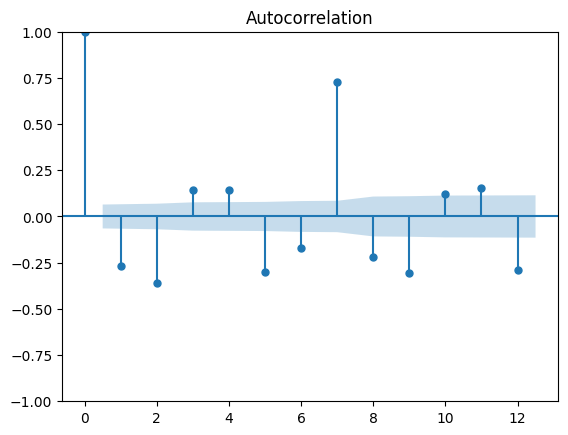

In [ ]:
plot_acf(df_arima['first_diff'].dropna(),lags=12)
plt.show()

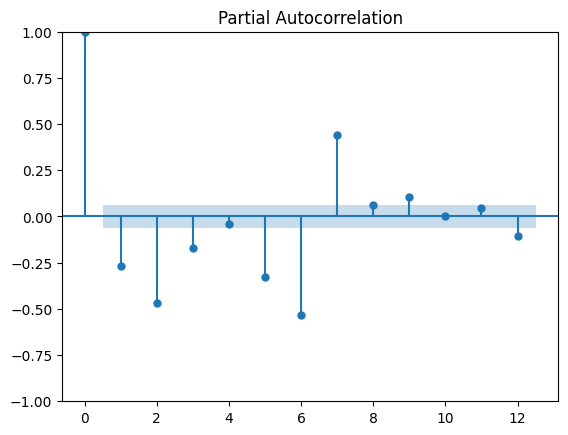

In [ ]:
plot_pacf(df_arima['first_diff'].dropna(),lags=12)
plt.show()

Taking value of p as 1 and q also as 1

In [ ]:
# p=1 ,q=1 , d=1
split_date = '2024-01-01'
df_train = df_arima.loc[df_arima.index <= split_date].copy()
df_test = df_arima.loc[df_arima.index > split_date].copy()

In [ ]:
df_train.tail(),df_test.head(),df_train.shape,df_test.shape

(             Value  first_diff  diff_12
 Date                                   
 2023-12-28  163118     -7263.0  20852.0
 2023-12-29  147758    -15360.0  -4105.0
 2023-12-30  154908      7150.0  -7577.0
 2023-12-31  159527      4619.0  -6651.0
 2024-01-01  154908     -4619.0 -26522.0,
              Value  first_diff  diff_12
 Date                                   
 2024-01-02  159527      4619.0 -13674.0
 2024-01-03  158227     -1300.0    998.0
 2024-01-04  154058     -4169.0  12133.0
 2024-01-05  155036       978.0  -6773.0
 2024-01-06  149747     -5289.0 -21631.0,
 (731, 3),
 (188, 3))

In [ ]:
ARIMA_model = ARIMA(df_train['Value'], order=(1,1,1))
ARIMA_model_fit = ARIMA_model.fit()

In [ ]:
prediction= ARIMA_model_fit.predict(start=df_test.index[0],end=df_test.index[-1])
len(prediction)

188

In [ ]:
prediction.head()

2024-01-02    157466.499672
2024-01-03    157945.941986
2024-01-04    158035.785630
2024-01-05    158052.621608
2024-01-06    158055.776535
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
df_arima['Arima Predictions'] = prediction
df_arima.tail()

,Value,first_diff,diff_12,Arima Predictions
Date,,,,
2024-07-03,181662,-5922.0,-11509.0,158056.504079
2024-07-04,177131,-4531.0,1012.0,158056.504079
2024-07-05,181447,4316.0,-7796.0,158056.504079
2024-07-06,178767,-2680.0,-10280.0,158056.504079
2024-07-07,195630,16863.0,15862.0,158056.504079


Clearly ARIMA model is not performing well. Lets try Sarima model

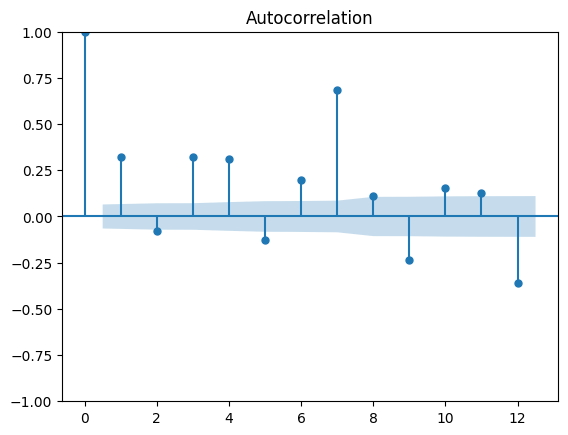

In [ ]:
plot_acf(df_arima['diff_12'].dropna(),lags=12)
plt.show()

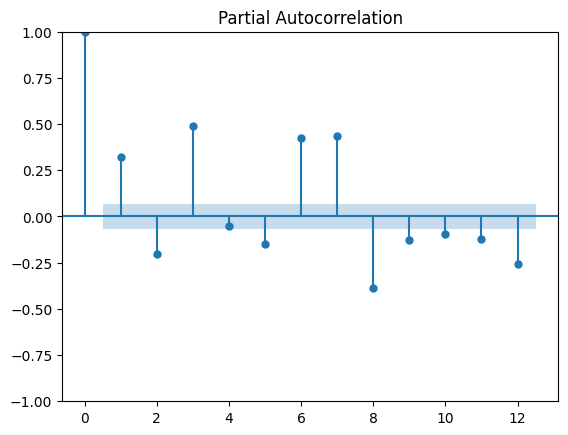

In [ ]:
plot_pacf(df_arima['diff_12'].dropna(),lags=12)
plt.show()

In [ ]:
# Value of p,d,q is 1,1,1
model = SARIMAX(df_train['Value'], order=(3,1,3),seasonal_order=(3,1,3,12))
model_fit = model.fit()

In [ ]:
prediction_sarima = model_fit.predict(start=df_test.index[0],end=df_test.index[-1])
len(prediction_sarima)

188

In [ ]:
df_arima['Sarima Predictions'] = prediction_sarima
df_arima.tail()

,Value,first_diff,diff_12,Arima Predictions,Sarima Predictions
Date,,,,,
2024-07-03,181662,-5922.0,-11509.0,158056.504079,172805.496858
2024-07-04,177131,-4531.0,1012.0,158056.504079,171399.743701
2024-07-05,181447,4316.0,-7796.0,158056.504079,169840.987591
2024-07-06,178767,-2680.0,-10280.0,158056.504079,170196.423296
2024-07-07,195630,16863.0,15862.0,158056.504079,172123.269265


In [ ]:
# Exploratory data analysis
fig = px.line(df_arima, x=df_arima.index, y=['Value','Sarima Predictions'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

ARIMA and SARIMAX are not performing well for this data even after trying different p,d,q combinations